# Phase 2 — QUBO Builder + Brute-force Sanity Checks (Portfolio Selection)

This notebook assumes you already have **Phase 1** (data/instance generation).  
To keep things modular (and prevent a huge notebook), we separate phases.

## What you’ll do here
1. Load Phase 1 instances **or** deterministically regenerate them.
2. Build the **QUBO** for penalized Markowitz portfolio selection:
   \[
   F_A(z)= q z^\top \Sigma z - (1-q)\mu^\top z + A(\sum_i z_i - B)^2
   \]
3. For small `n`, brute-force over all bitstrings to validate:
   - chosen penalty `A` enforces the budget constraint
   - the best penalized solution matches the best feasible solution

At the end, we save `Q` (QUBO coefficients) + metadata for Phase 3/4.


## 1) Imports

In [4]:
import os
import json
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Optional, Any

RNG = np.random.default_rng(123)

# --- Configure how to load instances ---
PHASE1_PKL_PATH = "phase1_instances.pkl"   # change if needed
USE_PHASE1_PKL = os.path.exists(PHASE1_PKL_PATH)

CONFIG = None
INSTANCE_SPECS = None
INSTANCE_REGISTRY = None

if USE_PHASE1_PKL:
    import pickle
    with open(PHASE1_PKL_PATH, "rb") as f:
        payload = pickle.load(f)
    CONFIG = payload["CONFIG"]
    INSTANCE_SPECS = payload["INSTANCE_SPECS"]
    INSTANCE_REGISTRY = payload["INSTANCE_REGISTRY"]
    print(f"Loaded Phase 1 artifacts from {PHASE1_PKL_PATH}. Instances:", len(INSTANCE_REGISTRY))
else:
    print(f"Did not find {PHASE1_PKL_PATH}. Will regenerate small synthetic instances below.")



Loaded Phase 1 artifacts from phase1_instances.pkl. Instances: 12


## 2) Define objective + QUBO builder

We work with binary selection vector $z\in\{0,1\}^n$.

- Markowitz objective (binary):
  \[
  F(z)= q\, z^\top \Sigma z - (1-q)\,\mu^\top z
  \]
- Budget constraint: \(\sum_i z_i = B\)

Penalty form:
\[
F_A(z) = F(z) + A(\sum_i z_i - B)^2.
\]

A QUBO is represented as a dictionary `Q[(i,j)]` for `i<=j`, so that:
\[
E(z) = \sum_{i\le j} Q_{ij} z_i z_j.
\]


In [ ]:
def markowitz_cost(z: np.ndarray, mu: np.ndarray, Sigma: np.ndarray, q: float) -> float:
    z = np.asarray(z, dtype=int)
    return float(q * (z @ Sigma @ z) - (1.0 - q) * (mu @ z))

def penalty_cost(z: np.ndarray, B: int, A: float) -> float:
    s = int(np.sum(z))
    return float(A * (s - B) ** 2)

def total_cost_penalized(z: np.ndarray, mu: np.ndarray, Sigma: np.ndarray, q: float, B: int, A: float) -> float:
    return markowitz_cost(z, mu, Sigma, q) + penalty_cost(z, B, A)

# Build QUBO - dictionary representation
def build_qubo_markowitz(mu: np.ndarray, Sigma: np.ndarray, q: float, B: int, A: float) -> Dict[Tuple[int,int], float]:
    """
    Build QUBO dict Q[(i,j)] for i<=j for:
      q z^T Sigma z - (1-q) mu^T z + A(sum z - B)^2
    using z_i^2 = z_i.
    """
    mu = np.asarray(mu).reshape(-1)
    Sigma = np.asarray(Sigma)
    n = mu.shape[0]

    Q: Dict[Tuple[int,int], float] = {}

    # Risk term: q * z^T Sigma z = q * (sum_i Sigma_ii z_i + 2 sum_{i<j} Sigma_ij z_i z_j)
    for i in range(n):
        Q[(i,i)] = Q.get((i,i), 0.0) + q * float(Sigma[i, i])
    for i in range(n):
        for j in range(i+1, n):
            Q[(i,j)] = Q.get((i,j), 0.0) + (2.0 * q * float(Sigma[i, j]))

    # Return term: -(1-q) * mu^T z  => linear on diagonal
    for i in range(n):
        Q[(i,i)] = Q.get((i,i), 0.0) - (1.0 - q) * float(mu[i])

    # Penalty: A (sum z - B)^2 = A( sum z + 2 sum_{i<j} z_i z_j - 2B sum z + B^2)
    # ignore constant A B^2
    for i in range(n):
        Q[(i,i)] = Q.get((i,i), 0.0) + A * (1.0 - 2.0 * B)
    for i in range(n):
        for j in range(i+1, n):
            Q[(i,j)] = Q.get((i,j), 0.0) + 2.0 * A

    return Q

def qubo_energy(z: np.ndarray, Q: Dict[Tuple[int,int], float]) -> float:
    z = np.asarray(z, dtype=int)
    E = 0.0
    for (i,j), v in Q.items():
        E += v * z[i] * z[j]
    return float(E)


## 3) Brute force solver (small n)

In [11]:
def brute_force_best(n: int, energy_fn):
    """
    Enumerate all 2^n bitstrings. Returns:
      (best_z, best_E)
    """
    best_E = float("inf")
    best_z = None
    for bits in itertools.product([0,1], repeat=n):
        z = np.fromiter(bits, dtype=int, count=n)
        E = energy_fn(z)
        if E < best_E:
            best_E = E
            best_z = z.copy()
    return best_z, float(best_E)

def brute_force_best_feasible(n: int, B: int, energy_fn):
    best_E = float("inf")
    best_z = None
    for bits in itertools.product([0,1], repeat=n):
        z = np.fromiter(bits, dtype=int, count=n)
        if int(z.sum()) != B:
            continue
        E = energy_fn(z)
        if E < best_E:
            best_E = E
            best_z = z.copy()
    return best_z, float(best_E)


## 4) Sanity experiment: choose penalty A so the penalized optimum is feasible

For each instance, we will:
1) compute the *true* best feasible solution by brute force
2) sweep a grid of `A` values and compute the best penalized solution
3) track:
   - whether penalized optimum satisfies the budget
   - objective gap to the best feasible solution (measured on the original Markowitz objective)

This tells us what `A` is “big enough” without being ridiculously huge (which can cause scaling/precision issues later).

In [7]:
def analyze_A_sweep(mu, Sigma, q, B, A_grid):
    n = len(mu)

    # Best feasible (ground truth) w.r.t original Markowitz objective
    z_star, F_star = brute_force_best_feasible(n, B, lambda z: markowitz_cost(z, mu, Sigma, q))

    rows = []
    for A in A_grid:
        Q = build_qubo_markowitz(mu, Sigma, q, B, A)
        zA, EA = brute_force_best(n, lambda z: qubo_energy(z, Q))

        feasible = (int(zA.sum()) == B)
        F_zA = markowitz_cost(zA, mu, Sigma, q)
        gap = (F_zA - F_star)

        rows.append({
            "A": float(A),
            "feasible": bool(feasible),
            "sum(z)": int(zA.sum()),
            "F(zA)": float(F_zA),
            "F* (feasible best)": float(F_star),
            "gap_F": float(gap),
        })

    df = pd.DataFrame(rows)
    return df, z_star, F_star

# Run on one demo instance (keep n <= 12 for brute force speed)
demo_key = sorted(INSTANCE_REGISTRY.keys(), key=lambda k: (k[0], k[2]))[0]
inst = INSTANCE_REGISTRY[demo_key]
n, B, q = inst["n"], inst["B"], inst["q"]
mu, Sigma = inst["mu"], inst["Sigma"]

print("Demo key:", demo_key, " n=", n, "B=", B, "q=", q)

A_grid = np.concatenate([
    np.array([0.0, 0.1, 0.2, 0.5, 1.0]),
    np.logspace(0, 4, 9)  # 1 ... 10000
])

dfA, z_star, F_star = analyze_A_sweep(mu, Sigma, q, B, A_grid)
dfA


Demo key: (8, 4, 0.2, 'synthetic_factor', 2025)  n= 8 B= 4 q= 0.2


,A,feasible,sum(z),F(zA),F* (feasible best),gap_F
0,0.000000,False,1,-0.002257,0.033446,-0.035703
1,0.100000,True,4,0.033446,0.033446,0.000000
2,0.200000,True,4,0.033446,0.033446,0.000000
3,0.500000,True,4,0.033446,0.033446,0.000000
4,1.000000,True,4,0.033446,0.033446,0.000000
5,1.000000,True,4,0.033446,0.033446,0.000000
6,3.162278,True,4,0.033446,0.033446,0.000000
7,10.000000,True,4,0.033446,0.033446,0.000000
8,31.622777,True,4,0.033446,0.033446,0.000000
9,100.000000,True,4,0.033446,0.033446,0.000000


### Plot feasibility and gap vs A

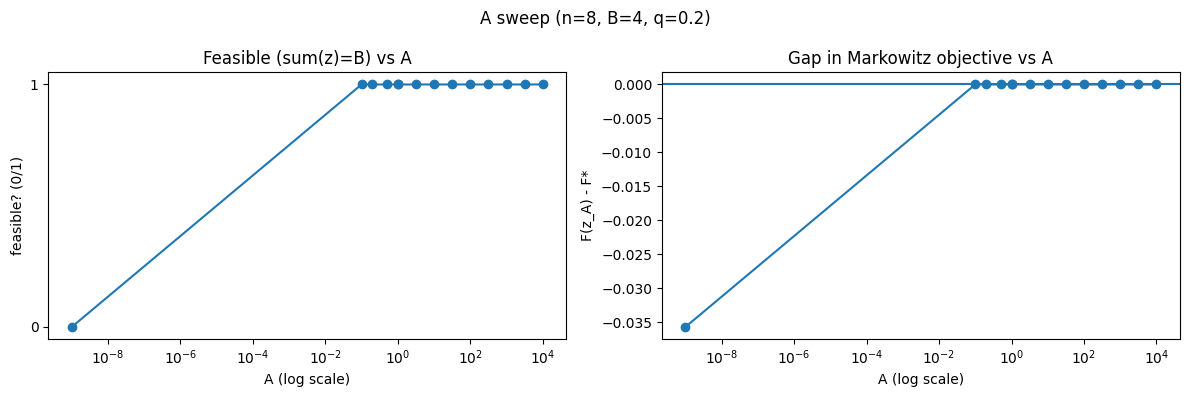

In [8]:
def plot_A_sweep(dfA: pd.DataFrame, title: str = ""):
    x = dfA["A"].to_numpy()
    feas = dfA["feasible"].astype(int).to_numpy()
    gap = dfA["gap_F"].to_numpy()

    fig = plt.figure(figsize=(12,4))

    ax1 = fig.add_subplot(1,2,1)
    ax1.semilogx(np.maximum(x, 1e-9), feas, marker="o")
    ax1.set_title("Feasible (sum(z)=B) vs A")
    ax1.set_xlabel("A (log scale)")
    ax1.set_ylabel("feasible? (0/1)")
    ax1.set_yticks([0,1])

    ax2 = fig.add_subplot(1,2,2)
    ax2.semilogx(np.maximum(x, 1e-9), gap, marker="o")
    ax2.axhline(0.0)
    ax2.set_title("Gap in Markowitz objective vs A")
    ax2.set_xlabel("A (log scale)")
    ax2.set_ylabel("F(z_A) - F*")

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_A_sweep(dfA, title=f"A sweep (n={n}, B={B}, q={q})")


## 5) Batch: pick an A rule and build QUBOs for all instances

Now we’ll choose a simple `A` rule.

For now, we use:
- `A = A_base * max(|Q_{ij}|)` **after** building the raw (A=0) objective terms,
or simply a constant like `A=100` for small instances.

We’ll implement a helper that computes a *scale-aware* A:
1) build Q for A=0
2) compute `scale = max(abs(coeffs))` (ignore zeros)
3) set `A = A_mult * scale`

This keeps penalty magnitudes on the same order as objective coefficients.

In [9]:
def qubo_coeff_scale(Q: Dict[Tuple[int,int], float]) -> float:
    vals = np.array([abs(v) for v in Q.values() if abs(v) > 0])
    return float(vals.max()) if vals.size else 1.0

def choose_A_scale_aware(mu, Sigma, q, B, A_mult: float = 10.0) -> float:
    Q0 = build_qubo_markowitz(mu, Sigma, q, B, A=0.0)
    scale = qubo_coeff_scale(Q0)
    return float(A_mult * scale)

def build_qubo_registry(instance_registry, A_mult: float = 10.0):
    qubo_registry = {}
    for key, inst in instance_registry.items():
        mu, Sigma, n, B, q = inst["mu"], inst["Sigma"], inst["n"], inst["B"], inst["q"]
        A = choose_A_scale_aware(mu, Sigma, q, B, A_mult=A_mult)
        Q = build_qubo_markowitz(mu, Sigma, q, B, A=A)
        qubo_registry[key] = {**inst, "A": A, "Q": Q}
    return qubo_registry

QUBO_REGISTRY = build_qubo_registry(INSTANCE_REGISTRY, A_mult=10.0)
print("Built QUBOs:", len(QUBO_REGISTRY))
next(iter(QUBO_REGISTRY.items()))[1]["A"]


Built QUBOs: 12


1.0508940249989034

## 6) Save artifacts for Phase 3/4

We’ll save a lightweight JSON + NumPy bundle.

- QUBO dicts are not NumPy arrays, so we store them in JSON-friendly form:
  `[(i,j,val), ...]` for each instance key.


In [10]:
def qubo_to_triplets(Q: Dict[Tuple[int,int], float]):
    return [(int(i), int(j), float(v)) for (i,j), v in Q.items()]

def triplets_to_qubo(trips):
    return {(int(i), int(j)): float(v) for (i,j,v) in trips}

artifact = {
    "CONFIG": CONFIG,
    "INSTANCE_KEYS": [],
    "INSTANCES": {},
}

for key, inst in QUBO_REGISTRY.items():
    key_str = str(key)
    artifact["INSTANCE_KEYS"].append(key_str)
    artifact["INSTANCES"][key_str] = {
        "n": int(inst["n"]),
        "B": int(inst["B"]),
        "q": float(inst["q"]),
        "seed": int(inst.get("seed", 0)),
        "A": float(inst["A"]),
        "mu": inst["mu"].tolist(),
        "Sigma": inst["Sigma"].tolist(),
        "Q_triplets": qubo_to_triplets(inst["Q"]),
        "meta": inst.get("meta", {}),
    }

out_json = "phase2_qubo_artifacts.json"
with open(out_json, "w") as f:
    json.dump(artifact, f)

print("Saved:", out_json)

# Quick reload test
with open(out_json, "r") as f:
    loaded = json.load(f)

sample_key = loaded["INSTANCE_KEYS"][0]
Q_loaded = triplets_to_qubo(loaded["INSTANCES"][sample_key]["Q_triplets"])
print("Reloaded Q size:", len(Q_loaded))


Saved: phase2_qubo_artifacts.json
Reloaded Q size: 36


✅ Phase 2 complete.

Next (Phase 3): *Solve* these QUBOs using:
- ExactSolver / brute force (small n)
- simulated annealing baseline
- (optional) D-Wave sampler / hybrid solver (if available)

We’ll load `phase2_qubo_artifacts.json` and produce comparison plots + tables.
